In [1]:
import os, shutil
import tensorflow as tf



In [2]:
original_dataset_dir = '/floyd/input/skin_disease_dataset/train'

In [3]:
os.listdir('/floyd/input/skin_disease_dataset/train')

['Eczema Photos',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Warts Molluscum and other Viral Infections',
 'Exanthems and Drug Eruptions',
 'Lupus and other Connective Tissue diseases',
 'Acne and Rosacea Photos',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Herpes HPV and other STDs Photos',
 'Urticaria Hives',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Light Diseases and Disorders of Pigmentation',
 'Nail Fungus and other Nail Disease',
 'Vasculitis Photos',
 'Bullous Disease Photos',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Atopic Dermatitis Photos',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Vascular Tumors']

In [4]:
import numpy as np
import pandas as pd

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#from tensorflow.keras.applications.vgg16 import  preprocess_input
from tensorflow.keras.applications.inception_v3 import  preprocess_input

In [6]:
img_width, img_height = 224, 224

In [7]:
def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a = preprocess_input(a)
    return a

In [8]:
res = preprocess_image("/floyd/input/skin_disease_dataset/train/Acne and Rosacea Photos/07Acne081101.jpg")
print(res)

[[[[ 0.21568632 -0.05098039 -0.12156862]
   [ 0.254902   -0.01960784 -0.06666666]
   [ 0.26274514 -0.01176471 -0.04313725]
   ...
   [ 0.19215691 -0.11372548 -0.16862744]
   [ 0.21568632 -0.09019607 -0.14509803]
   [ 0.20784318 -0.09803921 -0.15294117]]

  [[ 0.27058828  0.00392163 -0.06666666]
   [ 0.27843142  0.00392163 -0.04313725]
   [ 0.27843142  0.00392163 -0.02745098]
   ...
   [ 0.06666672 -0.23921567 -0.29411763]
   [ 0.2313726  -0.0745098  -0.11372548]
   [ 0.28627455 -0.00392157 -0.05098039]]

  [[ 0.254902   -0.01176471 -0.08235294]
   [ 0.23921573 -0.03529412 -0.08235294]
   [ 0.254902   -0.01960784 -0.05098039]
   ...
   [ 0.30980396  0.00392163 -0.03529412]
   [ 0.30980396  0.01176476 -0.01176471]
   [ 0.19215691 -0.10588235 -0.12941176]]

  ...

  [[ 0.2313726  -0.05882353 -0.12941176]
   [ 0.21568632 -0.05098039 -0.12156862]
   [ 0.27843142  0.0196079  -0.01960784]
   ...
   [-0.92156863 -0.9529412  -0.9764706 ]
   [-0.9137255  -0.94509804 -0.96862745]
   [-0.92941177 

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

HEIGHT = 224
WIDTH = 224

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "/floyd/input/skin_disease_dataset/train"
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)


test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )
validation_generator = test_datagen.flow_from_directory(
        '/floyd/input/skin_disease_dataset/test',
        target_size=(224, 224),
        batch_size=BATCH_SIZE)

Found 15557 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


In [11]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

class_list = os.listdir("/floyd/input/skin_disease_dataset/train")
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [12]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 180
BATCH_SIZE = 20
num_train_images = 15557

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(
    k=5, name='top_5'), tf.keras.metrics.TopKCategoricalAccuracy(
    k=3, name='top_3')])


checkpoint = ModelCheckpoint("resnet50.h5", monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history1 = finetune_model.fit(train_generator, epochs=NUM_EPOCHS, validation_data=(validation_generator),
                             workers=16, 
                             steps_per_epoch=num_train_images // BATCH_SIZE,
                             validation_steps = num_train_images // BATCH_SIZE, shuffle=True, callbacks=callbacks_list)

Epoch 1/180
776/777 [============================>.] - ETA: 0s - loss: 3.5962 - accuracy: 0.1126 - top_5: 0.3702 - top_3: 0.2539
Epoch 00001: saving model to resnet50.h5
777/777 [==============================] - 66s 85ms/step - loss: 3.5958 - accuracy: 0.1126 - top_5: 0.3702 - top_3: 0.2537 - val_loss: 2.7650 - val_accuracy: 0.2119 - val_top_5: 0.5261 - val_top_3: 0.4085
Epoch 2/180
777/777 [==============================] - ETA: 0s - loss: 2.9337 - accuracy: 0.1615 - top_5: 0.4337 - top_3: 0.3174
Epoch 00002: saving model to resnet50.h5
777/777 [==============================] - 71s 91ms/step - loss: 2.9337 - accuracy: 0.1615 - top_5: 0.4337 - top_3: 0.3174 - val_loss: 2.7256 - val_accuracy: 0.2103 - val_top_5: 0.5545 - val_top_3: 0.4259
Epoch 3/180
777/777 [==============================] - ETA: 0s - loss: 2.8687 - accuracy: 0.1753 - top_5: 0.4581 - top_3: 0.3388
Epoch 00003: saving model to resnet50.h5
777/777 [==============================] - 73s 94ms/step - loss: 2.8687 - accura

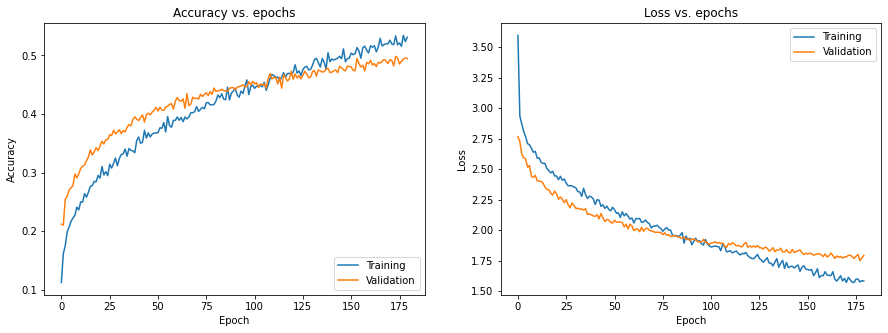

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
except KeyError:
    plt.plot(history1.history['acc'])
    plt.plot(history1.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
model = tf.keras.models.load_model('resnet50.h5')
pred= model.predict_generator(validation_generator, 4002)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
# labels2 = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]
# print(predicted_class_indices)
# print (labels)
# print (predictions)

In [ ]:
print (confusion_matrix(predicted_class_indices,labels))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
model = tf.keras.models.load_model('resnet50.h5')
res = preprocess_image("/floyd/input/skin_disease_dataset/train/Acne and Rosacea Photos/07Acne081101.jpg")
Y_pred = model.predict(validation_generator)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ['Urticaria Hives', 'Seborrheic Keratoses and other Benign Tumors', 'Poison Ivy Photos and other Contact Dermatitis', 'Acne and Rosacea Photos', 'Vascular Tumors', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases', 'Exanthems and Drug Eruptions', 'Lupus and other Connective Tissue diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Bullous Disease Photos', 'Nail Fungus and other Nail Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Systemic Disease', 'Light Diseases and Disorders of Pigmentation', 'Atopic Dermatitis Photos', 'Warts Molluscum and other Viral Infections', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Melanoma Skin Cancer Nevi and Moles', 'Vasculitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos']
matrix = confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Urticaria Hives', 'Seborrheic Keratoses and other Benign Tumors', 'Poison Ivy Photos and other Contact Dermatitis', 'Acne and Rosacea Photos', 'Vascular Tumors', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases', 'Exanthems and Drug Eruptions', 'Lupus and other Connective Tissue diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Bullous Disease Photos', 'Nail Fungus and other Nail Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Systemic Disease', 'Light Diseases and Disorders of Pigmentation', 'Atopic Dermatitis Photos', 'Warts Molluscum and other Viral Infections', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Melanoma Skin Cancer Nevi and Moles', 'Vasculitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [ ]:
import seaborn as sns 
p = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion Matrix', y=1.1)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
fig.colorbar(cax)
plt.title('Confusion matrix of the classifier')

In [ ]:
top1 = 0.0
top5 = 0.0    
class_probs = model.predict(x)
for i, l in enumerate(labels):
    class_prob = class_probs[i]
    top_values = (-class_prob).argsort()[:5]
    if top_values[0] == l:
        top1 += 1.0
    if np.isin(np.array([l]), top_values):
        top5 += 1.0

print("top1 acc", top1/len(labels))
print("top1 acc", top5/len(labels))